<a href="https://colab.research.google.com/github/Dutta-SD/3D_Medical_Experiments/blob/main/Update_1_Baseline_ML_Superised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Establishment



# Setup Environment

In [1]:
%%bash
# download data from the website
# tensorboard warning -- ignore

pip3 install -qq monai
pip3 install -qq pytorch-lightning
pip3 install -qq tensorboard

# Import Necessary Libraries

In [2]:
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.networks.nets import VNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint \
    import ModelCheckpoint
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import tqdm

print_config()

MONAI version: 0.6.0
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Utility function

# Set Root directory to be used with Monai Package

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpdbjch5rc


# Download The Data

In [4]:
# Spleen Dataset from MedicalDecathlon
# Originally Segmentation, but here we will use bounding box prediction

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

/usr/local/lib/python3.7/dist-packages/monai/apps/utils.py:82: UserWarning: tqdm is not installed, will not show the downloading progress bar.
  warnings.warn("tqdm is not installed, will not show the downloading progress bar.")


Downloaded: /tmp/tmpdbjch5rc/Task09_Spleen.tar
Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
Writing into directory: /tmp/tmpdbjch5rc.


# Define Network with Monai and PyTorch-Lightning

In [5]:
%%bash
rm -rf ./Task09_Spleen

In [6]:
'''
CHANGE FOR BOUNDING BOX DETECTION
1. Change Loss function
2. Add output Layer
'''
class ModifiedNet(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = VNet(
            spatial_dims = 3,
            in_channels=1,
            out_channels=2,
            # kernel_size=(32, 64, 128),
            # upsample_kernel_size=(128, 64, 32),
            # strides=(2, 2, 2),
            # # num_res_units=2,
            # norm_name=Norm.BATCH,
        )
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
        self.post_label = AsDiscrete(to_onehot=True, n_classes=2)
        self.best_val_dice = 0
        self.best_val_epoch = 0

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # set up the correct data path
        train_images = sorted(
            glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        train_labels = sorted(
            glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
        data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files = data_dicts[:-9], data_dicts[-9:]

        # set deterministic training for reproducibility
        set_determinism(seed=0)

        # define the data transforms
        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                # randomly crop out patch samples from
                # big image based on pos / neg ratio
                # the image centers of negative samples
                # must be in valid image area
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),

                ToTensord(keys=["image", "label"]),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        )

        # we use cached datasets - these are 10x faster than regular datasets
        self.train_ds = CacheDataset(
            data=train_files, transform=train_transforms,
            cache_rate=1.0, num_workers=4,
        )
        self.val_ds = CacheDataset(
            data=val_files, transform=val_transforms,
            cache_rate=1.0, num_workers=4,
        )
        # self.train_ds = monai.data.Dataset(
        #     data=train_files, transform=train_transforms)
        # self.val_ds = monai.data.Dataset(
        #     data=val_files, transform=val_transforms)

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds, batch_size=2, shuffle=True,
            num_workers=4, collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, num_workers=4)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def mixup(self, images, labels, apply=True):
        '''images, labels - one batch
        mix_coeff (min value) - coefficient for mixing
        '''

        if not apply:
            return images, labels

        one_img, one_label = images[0], labels[0]
        mix_coeff = torch.rand(1, device = self.device, requires_grad=False)
        mix_coeff = min(mix_coeff, 1 - mix_coeff)

        images = mix_coeff * one_img + (1 - mix_coeff) * images
        labels = mix_coeff * one_label + (1 - mix_coeff) * labels

        return images, labels


    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]

        images, labels = self.mixup(images, labels, apply=True)        

        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (160, 160, 160)
        sw_batch_size = 2
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = self.post_pred(outputs)
        labels = self.post_label(labels)
        value = compute_meandice(
            y_pred=outputs,
            y=labels,
            include_background=False,
        )
        return {"val_loss": loss, "val_dice": value}

    def validation_epoch_end(self, outputs):
        val_dice, val_loss, num_items = 0, 0, 0
        for output in outputs:
            val_dice += output["val_dice"].sum().item()
            val_loss += output["val_loss"].sum().item()
            num_items += len(output["val_dice"])
        mean_val_dice = torch.tensor(val_dice / num_items)
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}

# Run the Model

In [7]:
# initialise the LightningModule
net = ModifiedNet()

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
# tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
#     save_dir=log_dir
# )
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(
        log_dir, "{epoch}-{val_loss:.2f}-{val_dice:.2f}")
)

# initialise Lightning's trainer.

# IDEAL EPOCHS - 600
trainer = pytorch_lightning.Trainer(
    # UNCOMMENT BELOW LINE TO USE GPU
    gpus=[0],
    max_epochs=2,
    checkpoint_callback=checkpoint_callback,
    num_sanity_val_steps=1,
    precision = 16,
    accumulate_grad_batches=8,
    
)

# train
trainer.fit(net)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:597: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | VNet     | 45.6 M
1 | loss_function | DiceLoss | 0     
-------------------------------------------
45.6 M    Trainable params
0         Non-trainable params
45.6 M    Total params
182.401   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


current epoch: 0 current mean dice: 0.4989
best mean dice: 0.4989 at epoch: 0


current epoch: 0 current mean dice: 0.4980
best mean dice: 0.4989 at epoch: 0


current epoch: 1 current mean dice: 0.4980
best mean dice: 0.4989 at epoch: 0



# Show the best score

In [8]:
print(
    f"train completed, best_metric: {net.best_val_dice:.4f} "
    f"at epoch {net.best_val_epoch}")

train completed, best_metric: 0.4989 at epoch 0


# Visualise the results

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


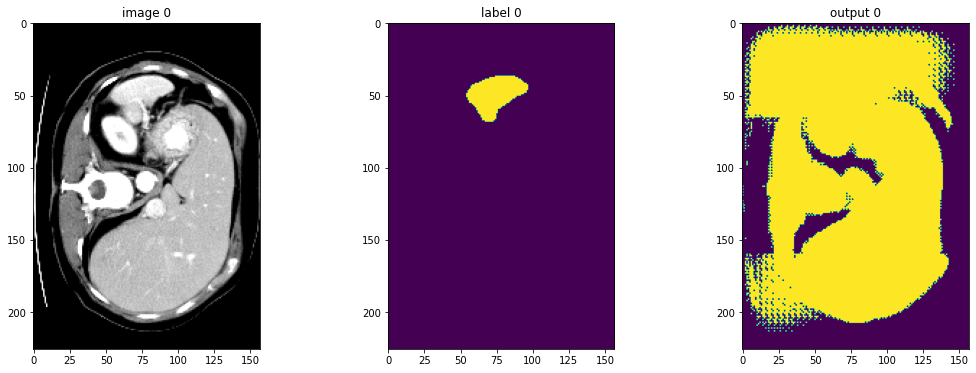

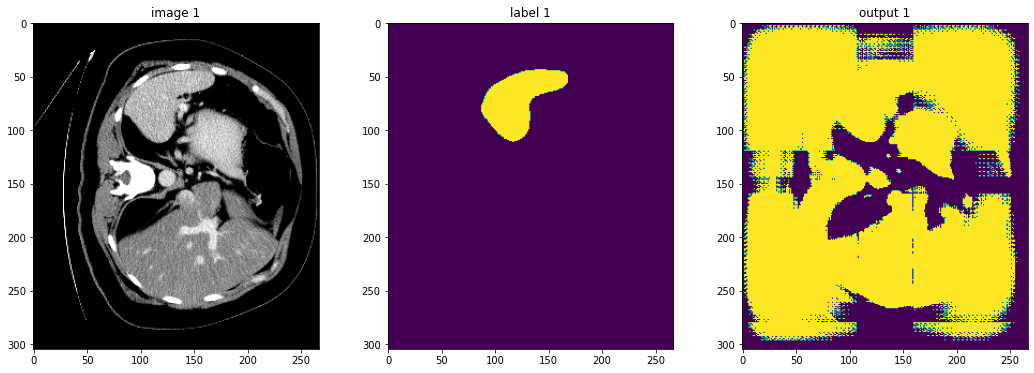

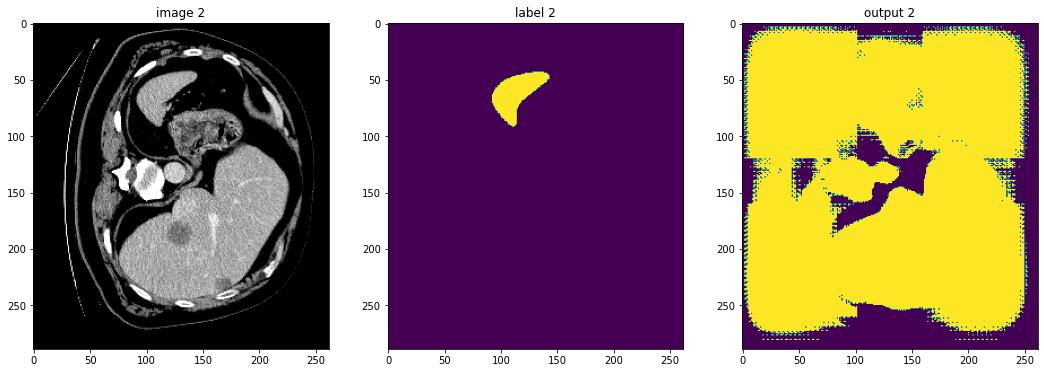

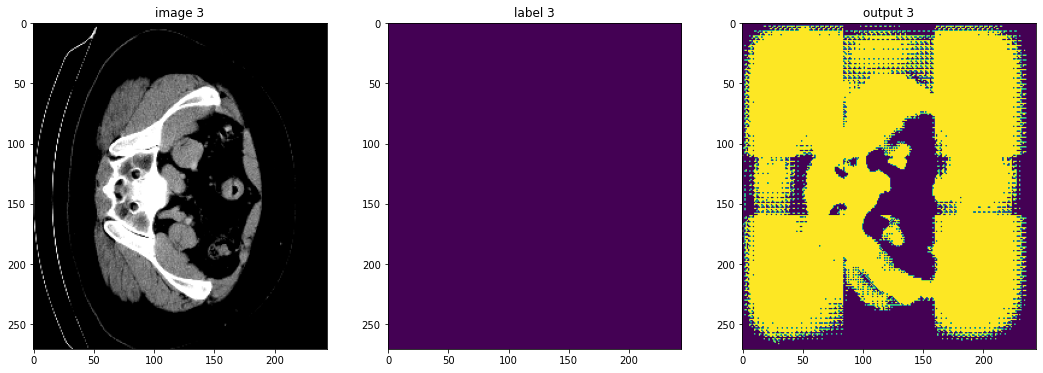

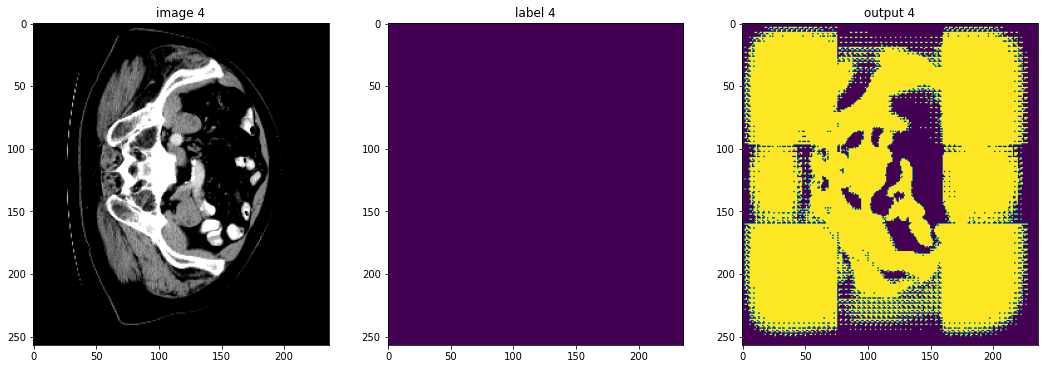

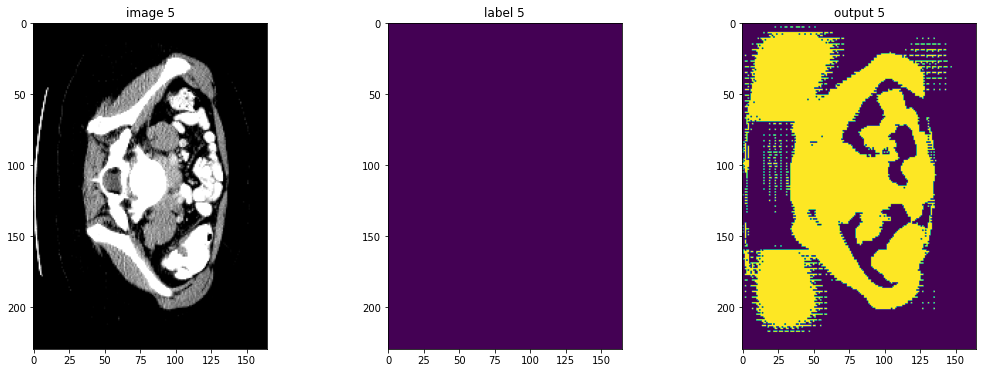

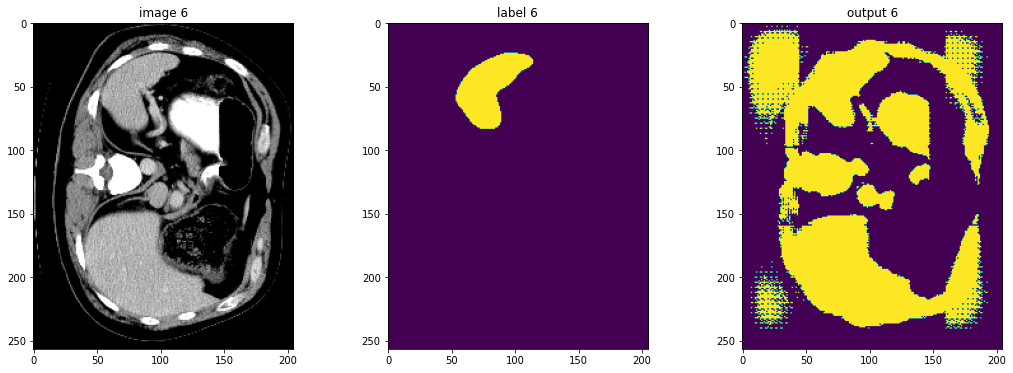

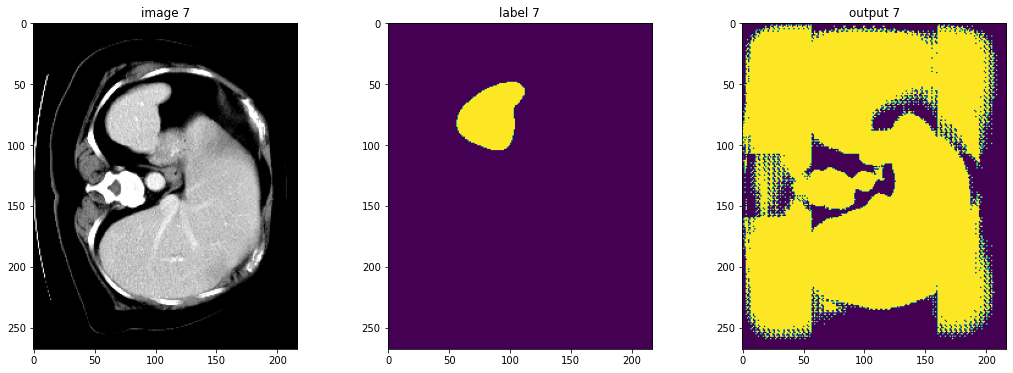

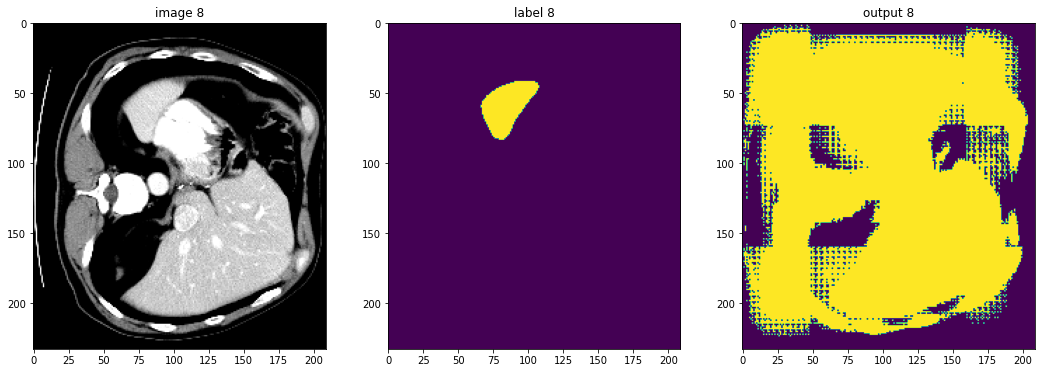

In [9]:
net.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()

# Sources

[Monai Tutorial](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d_lightning.ipynb)